In [100]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 

In [101]:
df = pd.read_parquet('../data/cleaned/weather.parquet')
df['time'] = pd.to_datetime(df['time'])
df.isna().sum()

time                             0
temperature                      0
relative_humidity                0
dew_point                        0
precipitation (mm)               0
rain (mm)                        0
snowfall (cm)                    0
pressure_msl (hPa)               0
surface_pressure (hPa)           0
cloud_cover (%)                  0
cloud_cover_low (%)              0
cloud_cover_mid (%)              0
cloud_cover_high (%)             0
vapour_pressure_deficit (kPa)    0
wind_speed_10m (km/h)            0
wind_direction                   0
is_Day                           0
dtype: int64

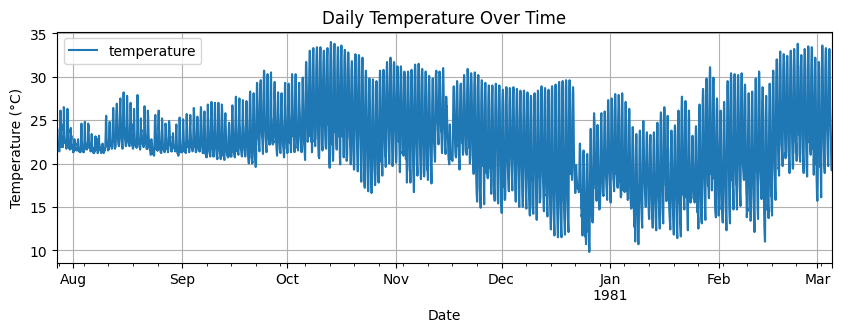

In [102]:
df[5000:10300].plot(x='time', y='temperature', kind='line', figsize=(10,3))
plt.title('Daily Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.grid()
plt.show()

In [103]:
df['time'] = pd.to_datetime(df['time'])
# Ensure the 'time' column is set as the DataFrame time for time-based operations
df.set_index('time', inplace=True)

# Calculate the difference with the value from 24 hours ago
df['temperature_diff_24h'] = df['temperature'] - df['temperature'].shift(freq='24h')

# Reset time if needed for further processing
df.reset_index(inplace=True)
# df[85:100]
df = df.dropna().reset_index(drop=True)

df.drop(columns=['snowfall (cm)'], inplace=True)

## Stationarity Analysis

In [104]:
# ## Stationarity Analysis
# from statsmodels.tsa.stattools import adfuller, kpss
# import warnings
# warnings.filterwarnings('ignore')

# def stationarity_analysis(df, dataset_name, column_name = None):
#     """
#     column_name: specify the column to analyze, default is 'Close'
#     Perform ADF and KPSS tests for stationarity analysis
#     """
#     data = df['Close'] if column_name is None else df[column_name]
    
#     data.dropna(inplace=True)  # Drop NaN values for accurate testing
    
#     print(f"\n{'='*50}")
#     print(f"STATIONARITY ANALYSIS: {dataset_name.upper()}")
#     print(f"{'='*50}")
    
#     # ADF Test
#     print("\n--- AUGMENTED DICKEY-FULLER TEST ---")
#     adf_result = adfuller(data, autolag='AIC')
#     print(f"ADF Statistic: {adf_result[0]:.6f}")
#     print(f"p-value: {adf_result[1]:.6f}")
#     print("Critical Values:")
#     for key, value in adf_result[4].items():
#         print(f"\t{key}: {value:.6f}")
    
#     if adf_result[1] <= 0.05:
#         print("ADF Result: STATIONARY (Reject null hypothesis)")
#     else:
#         print("ADF Result: NON-STATIONARY (Fail to reject null hypothesis)")
    
#     # KPSS Test
#     print("\n--- KWIATKOWSKI-PHILLIPS-SCHMIDT-SHIN TEST ---")
#     kpss_result = kpss(data, regression='c', nlags='auto')
#     print(f"KPSS Statistic: {kpss_result[0]:.6f}")
#     print(f"p-value: {kpss_result[1]:.6f}")
#     print("Critical Values:")
#     for key, value in kpss_result[3].items():
#         print(f"\t{key}: {value:.6f}")
    
#     if kpss_result[1] <= 0.05:
#         print("KPSS Result: NON-STATIONARY (Reject null hypothesis)")
#     else:
#         print("KPSS Result: STATIONARY (Fail to reject null hypothesis)")
    
#     # Combined interpretation
#     print("\n--- COMBINED INTERPRETATION ---")
#     adf_stationary = adf_result[1] <= 0.05
#     kpss_stationary = kpss_result[1] > 0.05
    
#     if adf_stationary and kpss_stationary:
#         print("CONCLUSION: Series is STATIONARY")
#     elif not adf_stationary and not kpss_stationary:
#         print("CONCLUSION: Series is NON-STATIONARY")
#     else:
#         print("CONCLUSION: Results are INCONCLUSIVE - further investigation needed")

# stationarity_analysis(df=df, dataset_name="temperature_Raws", column_name='temperature')
# stationarity_analysis(df=df, dataset_name="temperature_diff_24h", column_name='temperature_diff_24h')

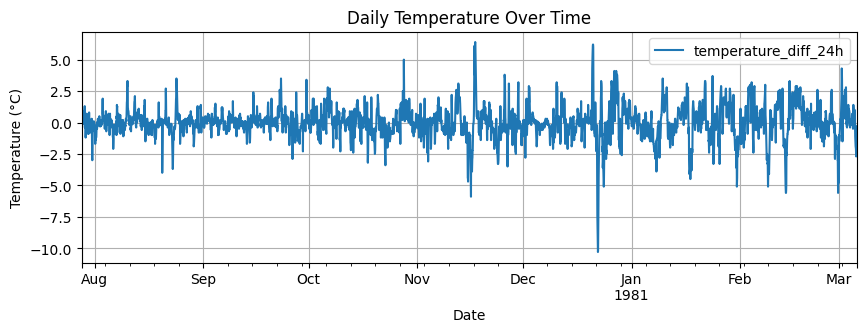

In [105]:
df[5000:10300].plot(x='time', y='temperature_diff_24h', kind='line', figsize=(10,3))
plt.title('Daily Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.grid()
plt.show()

In [106]:
mean_lr = df['temperature_diff_24h'].mean()
std_lr = df['temperature_diff_24h'].std()
CLAMP_STD = 3

upper = mean_lr + CLAMP_STD * std_lr
lower = mean_lr - CLAMP_STD * std_lr

df['temperature_diff_24h'] = np.where(df['temperature_diff_24h'] > upper, upper,
                        np.where(df['temperature_diff_24h'] < lower, lower, df['temperature_diff_24h']))

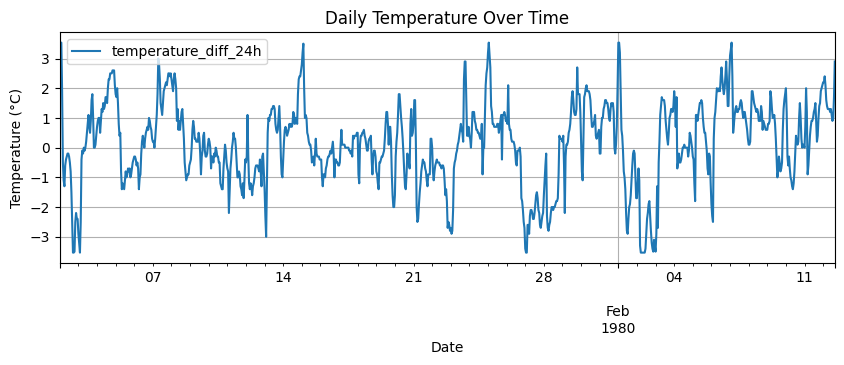

In [107]:
df[0:1000].plot(x='time', y='temperature_diff_24h', kind='line', figsize=(10,3))
plt.title('Daily Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.grid()
plt.show()

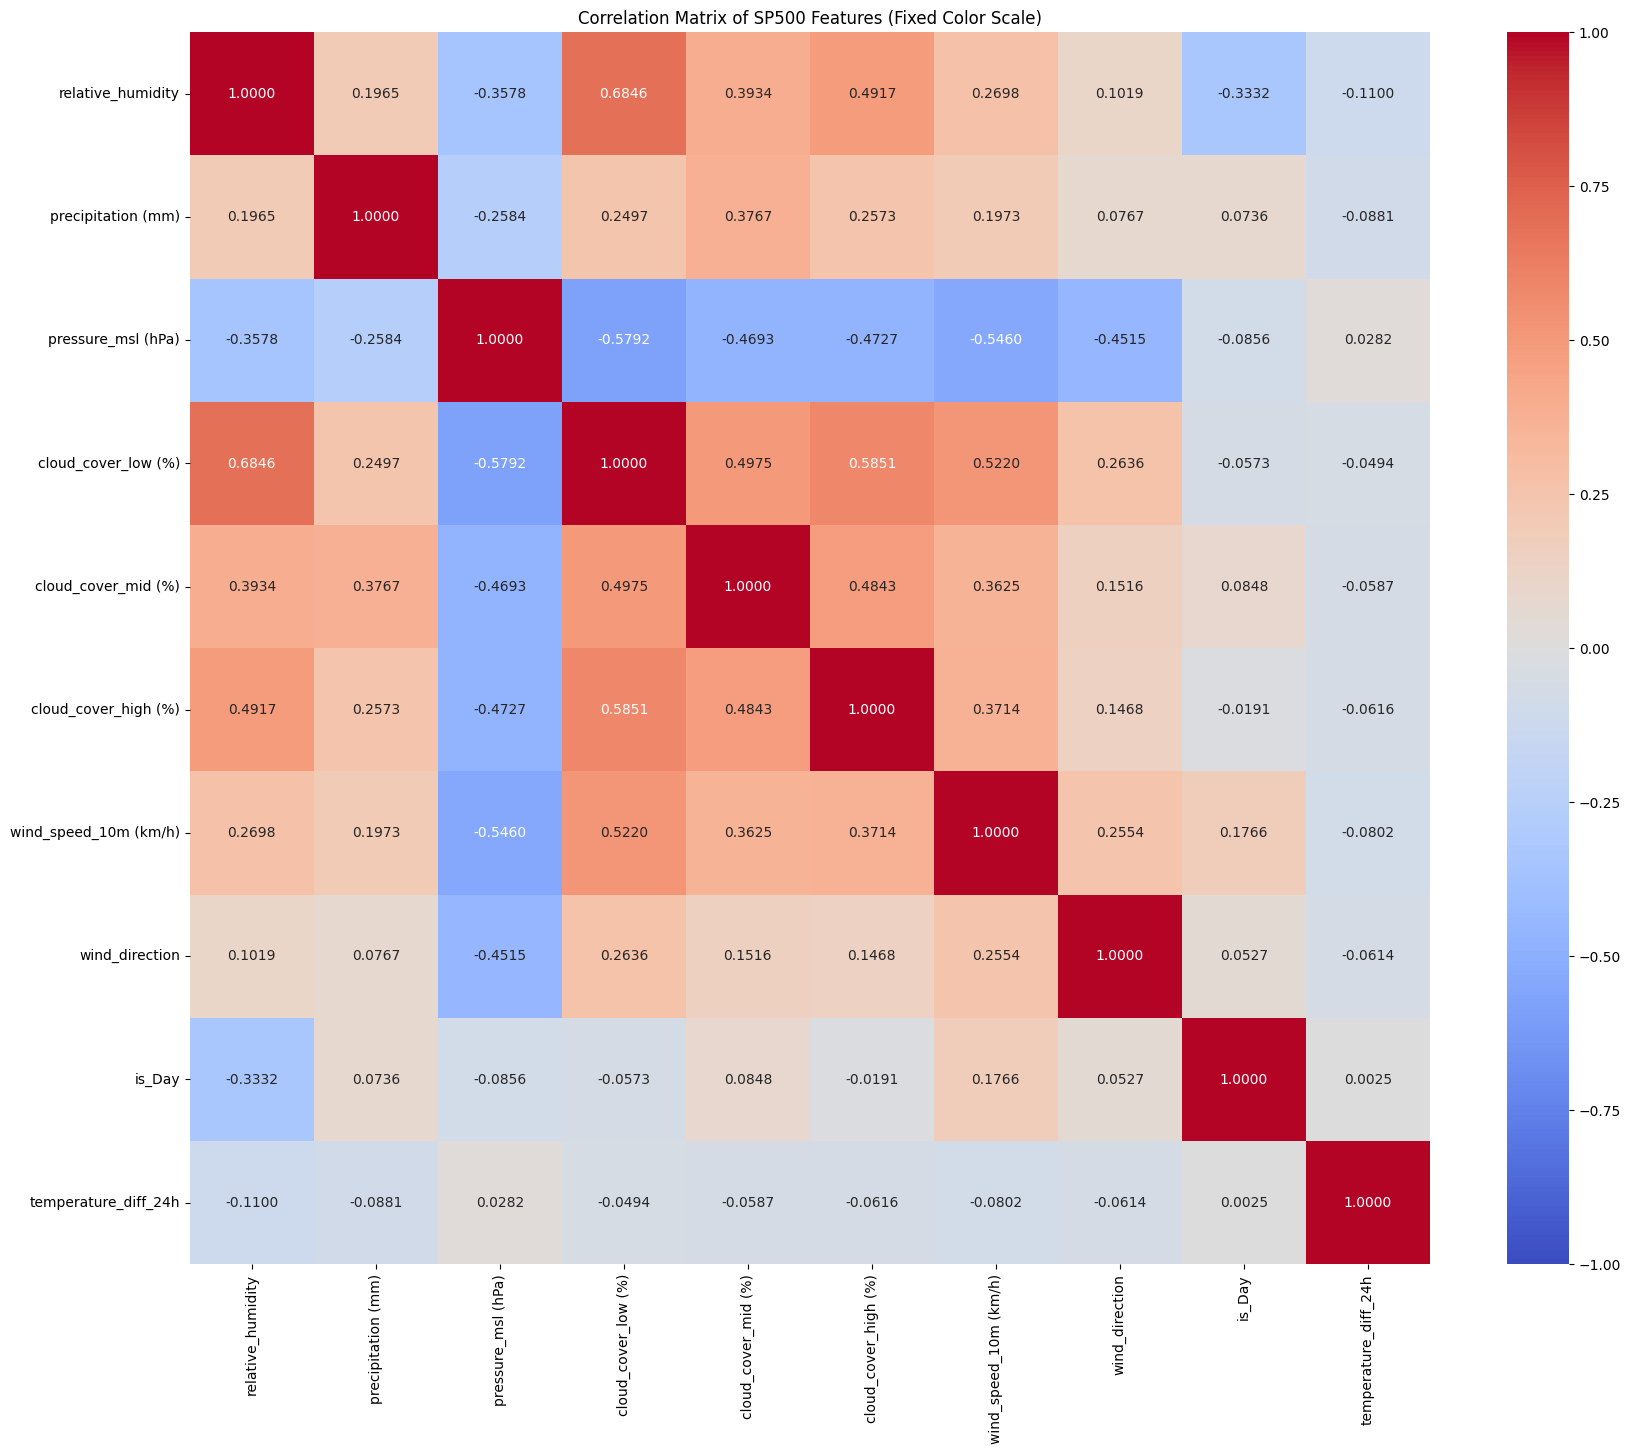

In [ ]:
highly_correlated_features = ['vapour_pressure_deficit (kPa)', 'dew_point', 'rain (mm)', 'surface_pressure (hPa)', 'cloud_cover (%)']
# highly_correlated_features = []
dfcorr = df.drop(columns=['time', 'temperature']+highly_correlated_features)

# Set vmin and vmax to fix the color scale between -1 and 1
plt.figure(figsize=(20, 16))
sns.heatmap(dfcorr.corr(), annot=True, fmt=".4f", cmap='coolwarm', cbar=True, vmin=-1, vmax=1)
plt.title('Correlation Matrix of SP500 Features (Fixed Color Scale)')
plt.savefig('../report/plots/weather_correlation_matrix_fixed_scale.pdf')
plt.show()